In [29]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit import BasicAer, execute
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 23
np.random.seed(algorithm_globals.random_seed)

backend = BasicAer.get_backend('qasm_simulator')

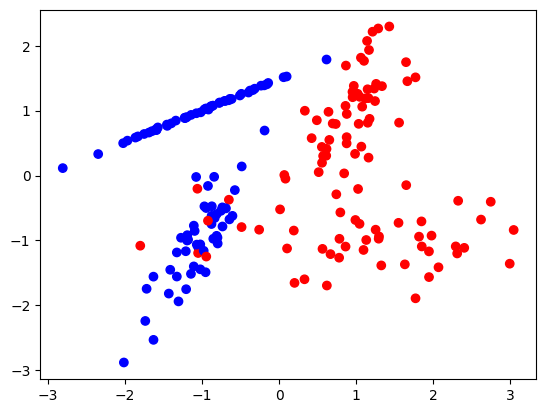

In [30]:
x, y = make_classification(n_samples=200, n_repeated=0, n_features=2, n_informative=2, n_redundant=0, random_state=23)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=23)
plt.scatter(x[:,0], x[:,1], c = ['red' if code == 1 else 'blue' for code in y]);

In [31]:
def variational_circuit(params):
    qc = QuantumCircuit(2,1)
    layers = int(len(params)/2)
    for l in range(layers):
        qc.ry(params[l], 0) ; qc.rx(params[l+1], 1) ; qc.cz(0,1)
    qc.measure(0,0)
    return qc

def angle_encoding(x):
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0) ; qc.ry(x[1], 1)
    return qc

def circuit(x, params):
    return angle_encoding(x).compose(variational_circuit(params))

variational_circuit(np.random.rand(6)).draw()

┌────────────┐   ┌─────────────┐   ┌─────────────┐   ┌─┐
q_0: ─┤ Ry(0.5173) ├─■─┤ Ry(0.94696) ├─■─┤ Ry(0.76546) ├─■─┤M├
     ┌┴────────────┤ │ ├─────────────┤ │ └┬────────────┤ │ └╥┘
q_1: ┤ Rx(0.94696) ├─■─┤ Rx(0.76546) ├─■──┤ Rx(0.2824) ├─■──╫─
     └─────────────┘   └─────────────┘    └────────────┘    ║ 
c: 1/═══════════════════════════════════════════════════════╩═
                                                            0

In [32]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def predict_prob(point, params):
    qc = circuit(point, params)
    results = execute(qc, backend).result()
    probs = label_probability(results.get_counts())
    return {0:probs[0], 1:probs[1]}

In [36]:
def cross_entropy_loss(classification, expected):
    p = classification.get(expected)  
    return -np.log(p + 1e-10)

def cost_function(x_train, y_train, params):
    cost = 0
    probs = [predict_prob(x, params) for x in x_train] 
    for i, prob in enumerate(probs):
        cost += cross_entropy_loss(prob, y_train[i])
    cost /= len(x_train)
    
    cost_list.append(cost)
    return cost

In [37]:
np.random.seed(algorithm_globals.random_seed)

cost_list = []
optimizer = SPSA(maxiter=100, )
objective_function = lambda params: cost_function(x_train, y_train, params)

params = np.random.rand(4)
opt = optimizer.minimize(objective_function, x0=params)

print('Initial Parameters:', params)
print('Optimal Parameters:', opt.x)

Initial Parameters: [0.51729788 0.9469626  0.76545976 0.28239584]
Optimal Parameters: [ 1.29656121  2.71314044  1.70039878 -0.40607277]


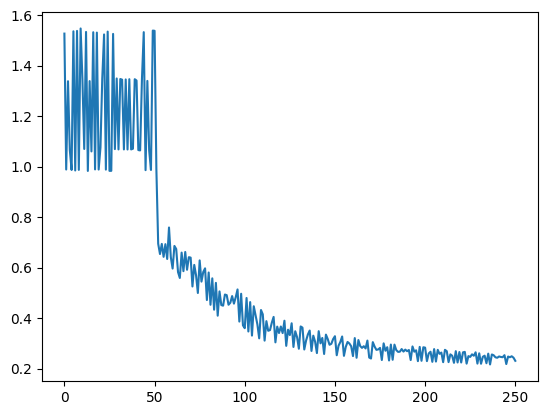

In [38]:
plt.plot(cost_list)

In [10]:
def predict(point, params):
    return [e for e in predict_prob(point, params).values()]

In [39]:
y_hat = [np.argmax(predict(x, opt.x)) for x in x_test]
accuracy_score(y_test, y_hat)

0.925

In [40]:
y_test.mean()

0.55